In [5]:
import os
import sys
import cv2
import csv
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils.file_dialog_utils import pick_video_cv2, pick_folder

# --- PART 1: LOADING & PREPARATION ---

def load_templates_with_names(folder_path):
    """
    Loads templates and keeps their filenames.
    Returns: list of (filename, image_bgr)
    """
    paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    template_data = []
    for p in paths:
        img = cv2.imread(p)
        if img is not None:
            filename = os.path.basename(p)
            template_data.append((filename, img))
    return template_data


def preprocess_templates_for_video(template_data):
    """
    Converts BGR templates to Grayscale ONCE to speed up video processing.
    Returns: list of (name, gray_image, width, height)
    """
    processed = []
    for name, img_bgr in template_data:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        processed.append((name, gray, w, h))
    return processed

# --- PART 2: MATCHING LOGIC ---

def find_best_match_fast(target_gray, gray_templates):
    """
    Optimized matcher for video. 
    Accepts PRE-CONVERTED gray templates to save time.
    """
    best_match = {
        "score": -1.0,
        "location": None,
        "width": 0,
        "height": 0,
        "name": ""
    }

    for name, tmpl_gray, w, h in gray_templates:
        res = cv2.matchTemplate(target_gray, tmpl_gray, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)

        if max_val > best_match["score"]:
            best_match["score"] = max_val
            best_match["location"] = max_loc
            best_match["width"] = w
            best_match["height"] = h
            best_match["name"] = name

    return best_match

In [6]:
# --- PART 3: SHAPE FITTING & VIDEO PROCESSING ---

def fit_circle_least_squares(points_xy: np.ndarray):
    """Least-squares circle fit. Returns (cx, cy, r)."""
    x = points_xy[:, 0]
    y = points_xy[:, 1]
    A = np.c_[2*x, 2*y, np.ones_like(x)]
    b = x**2 + y**2
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    cx, cy, c = sol
    r = math.sqrt(max(0.0, c + cx**2 + cy**2))
    return float(cx), float(cy), float(r)


def fit_ellipse(points_xy):
    """
    Fit an ellipse to (x,y) points using OpenCV.
    Needs >= 5 points.
    Returns: (center(x,y), axes(rx, ry), angle_deg)
    """
    pts = np.array(points_xy, dtype=np.float32).reshape(-1, 1, 2)
    (cx, cy), (MA, ma), angle = cv2.fitEllipse(pts)
    rx, ry = MA / 2.0, ma / 2.0
    return (float(cx), float(cy)), (float(rx), float(ry)), float(angle)


def distributed_frame_indices(total_frames: int, n: int):
    """
    Returns n indices spread across [0, total_frames-1].
    Ensures uniqueness and sorted order.
    """
    n = int(max(1, n))
    if total_frames <= 0:
        return [0]
    idx = np.linspace(0, max(0, total_frames-1), n, dtype=int)
    idx = np.unique(idx)
    return idx.tolist()


def process_video_sampled_frames(
    video_path: str,
    template_folder: str,
    n_samples: int = 30,
    min_score: float = 0.60,
):
    """
    Simplified pipeline:
      1) Sample N distributed frames from the video
      2) Template-match on ONLY those frames
      3) Collect accepted center points
      4) Fit ellipse (>=5 points) else circle fallback
      5) Overlay the fitted shape on the FIRST frame

    Params:
      - n_samples: how many distributed frames to evaluate (higher = better fit, slower)
      - min_score: NCC threshold
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Grab the first frame for overlay output
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ok, first_frame = cap.read()
    if not ok:
        cap.release()
        raise RuntimeError("Could not read first frame.")

    # Load templates
    templates_with_names = load_templates_with_names(template_folder)
    gray_templates = preprocess_templates_for_video(templates_with_names)

    sample_idxs = distributed_frame_indices(total_frames, n_samples)
    print(f"Total frames: {total_frames} | sampling {len(sample_idxs)} frames")

    rows = []

    for idx in sample_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        match = find_best_match_fast(gray, gray_templates)

        if match.get("location") is None:
            continue

        score = float(match["score"])
        if score < min_score:
            continue

        # center coordinate
        tlx, tly = match["location"]
        w, h = match["width"], match["height"]
        cx = tlx + w / 2.0
        cy = tly + h / 2.0

        rows.append({
            "frame_idx": int(idx),
            "center_x": float(cx),
            "center_y": float(cy),
            "score": score,
            "template": match.get("name", "")
        })

    cap.release()

    print(f"Accepted points: {len(rows)}")
    if not rows:
        print("No points accepted. Try lowering min_score or increasing n_samples.")
        return
    
    # Save CSV
    with open("zero_points.csv", "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["frame_idx", "center_x", "center_y", "score", "template"])
        writer.writeheader()
        writer.writerows(rows)
    print(f"Saved CSV: zero_points.csv")
    points_xy = [(r["center_x"], r["center_y"]) for r in rows]

    # Fit ellipse if possible, else circle fallback
    overlay = first_frame.copy()

    if len(points_xy) >= 5:
        (cx, cy), (rx, ry), angle = fit_ellipse(points_xy)
        cv2.ellipse(
            overlay,
            (int(cx), int(cy)),
            (int(rx), int(ry)),
            angle,
            0, 360,
            (0, 0, 255),
            3
        )
        cv2.circle(overlay, (int(cx), int(cy)), 4, (0, 255, 0), -1)
        print(f"Ellipse -> center=({cx:.1f},{cy:.1f}), axes=({rx:.1f},{ry:.1f}), angle={angle:.1f}°")
    else:
        pts = np.array(points_xy, dtype=np.float64)
        cx, cy, r = fit_circle_least_squares(pts)
        cv2.circle(overlay, (int(cx), int(cy)), int(r), (0, 0, 255), 3)
        cv2.circle(overlay, (int(cx), int(cy)), 4, (0, 255, 0), -1)
        print(f"Circle fallback -> center=({cx:.1f},{cy:.1f}), radius={r:.1f}px (need >=5 points for ellipse)")

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Fitted Ellipse Overlay on First Frame")
    plt.show()

In [7]:
def draw_ellipse_from_csv(
    video_path,
    csv_path,
    outer_inward_pct,  # less inward (outer halo edge)
    inner_inward_pct   # more inward (inner halo edge)
):
    rows = []
    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append({
                "center_x": float(r["center_x"]),
                "center_y": float(r["center_y"]),
            })

    if len(rows) < 5:
        raise ValueError("Need at least 5 points to fit an ellipse.")

    # Fit base ellipse (numbers ring)
    pts = np.array(
        [(r["center_x"], r["center_y"]) for r in rows],
        dtype=np.float32
    ).reshape(-1, 1, 2)

    (cx, cy), (MA, ma), angle = cv2.fitEllipse(pts)
    rx, ry = MA / 2.0, ma / 2.0

    # Halo boundaries (both inward)
    outer_rx = rx * (1.0 - outer_inward_pct)
    outer_ry = ry * (1.0 - outer_inward_pct)

    inner_rx = rx * (1.0 - inner_inward_pct)
    inner_ry = ry * (1.0 - inner_inward_pct)

    if inner_inward_pct <= outer_inward_pct:
        raise ValueError("inner_inward_pct must be greater than outer_inward_pct")

    # Random frame
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    random_idx = random.randint(0, total_frames - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, random_idx)
    ok, frame = cap.read()
    cap.release()

    if not ok:
        raise RuntimeError("Could not read random frame.")

    overlay = frame.copy()

    # Base ellipse (numbers)
    cv2.ellipse(
        overlay, (int(cx), int(cy)), (int(rx), int(ry)),
        angle, 0, 360, (0, 0, 255), 2
    )

    # Outer halo boundary
    cv2.ellipse(
        overlay, (int(cx), int(cy)), (int(outer_rx), int(outer_ry)),
        angle, 0, 360, (0, 165, 255), 2  # orange
    )

    # Inner halo boundary
    cv2.ellipse(
        overlay, (int(cx), int(cy)), (int(inner_rx), int(inner_ry)),
        angle, 0, 360, (0, 255, 0), 2  # green
    )

    # Display
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_rgb)

    # Legend (color-coded)
    base_legend  = mlines.Line2D([], [], color='red',   linewidth=2, label='Numbers ring (base ellipse)')
    outer_legend = mlines.Line2D([], [], color='orange', linewidth=2, label='Outer halo boundary')
    inner_legend = mlines.Line2D([], [], color='green', linewidth=2, label='Inner halo boundary')

    plt.legend(
        handles=[base_legend, outer_legend, inner_legend],
        loc='upper right',
        framealpha=0.9
    )

    plt.title(
        f"Halo band (inward offsets)\n"
        f"Outer: {outer_inward_pct*100:.1f}%  |  Inner: {inner_inward_pct*100:.1f}%  |  Frame {random_idx}"
    )

    plt.axis("off")
    plt.show()

Total frames: 222 | sampling 10 frames
Accepted points: 10
Saved CSV: zero_points.csv
Ellipse -> center=(488.3,394.5), axes=(256.8,275.8), angle=88.9°


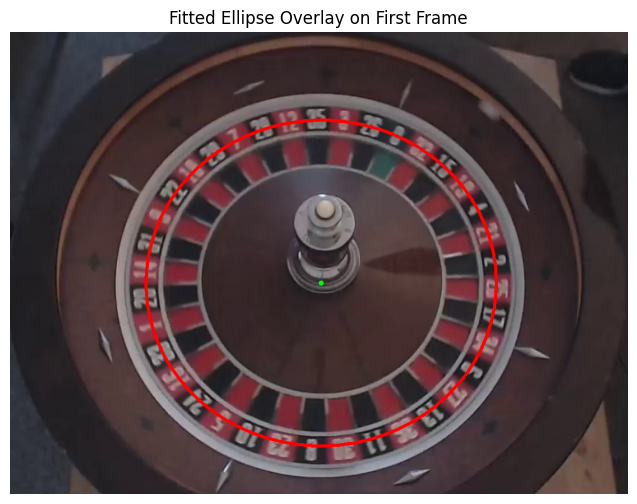

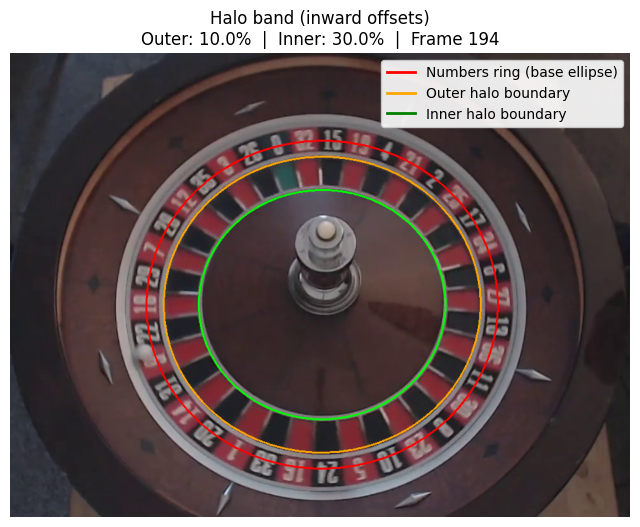

In [8]:
# --- MAIN EXECUTION ---

# Settings
_, input_video_path = pick_video_cv2(title="Select Input Video")
templates_dir = pick_folder(title="Select Template Folder")

N_SAMPLES = 10      # How many distributed frames to evaluate
MIN_SCORE = 0.80    # Lower if too few points are accepted

process_video_sampled_frames(
    video_path=input_video_path,
    template_folder=templates_dir,
    n_samples=N_SAMPLES,
    min_score=MIN_SCORE
)

draw_ellipse_from_csv(
    video_path=input_video_path,
    csv_path="zero_points.csv",
    outer_inward_pct=0.10,   
    inner_inward_pct=0.30
)